In [1]:
import keras
import tensorflow as tf

# Memory Pre-configuration
config = tf.compat.v1.ConfigProto(
    gpu_options=tf.compat.v1.GPUOptions(
        per_process_gpu_memory_fraction=0.9,
        allow_growth = True
    )
    # device_count = {'GPU': 1}
)
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

작은 이미지 데이터셋에 딥러닝을 적용하는 일반적이고 매우 효과적인 방법은 **사전 훈련된 네트워크**를 사용하는 것입니다. **사전 훈련된 네트워크 (Pretrained Network)**는 일반적으로 대량의 데이터셋에서 미리 훈련되어 저장된 네트워크입니다. 원본 데이터넷이 충분히 크고 일반적이라면 사전 훈련된 네트워크에 의해 학습된 특성의 계층 구조는 실제 세상에 대한 일반적인 모델로 효율적인 역할을 할 수 있습니다. 

여기에서는 1400만개의 레이블된 이미지와 1000개의 클래스로 이루어진 *ImageNet* 데이터셋에서 훈련된 대규모 컨브넷을 사용해 보겠습니다. ImageNet 데이터넷에는 다양한 종의 강아지와 고양이를 비롯하여 많은 동물 사진이 있습니다. 그래서 강아지와 고양이 분류 문제에 좋은 성능을 냅니다. VGG16은 간단하고 ImageNet 데이터넷에 널리 사용되는 컨브넷 구조입니다. 

사전 훈련된 네트워크를 사용하는 두가지 방법이 있습니다. **특성 추출 (feature extraction)**과 **미세 조정 (fine tuning)**입니다.

### 특성 추출

특성 추출은 사전에 학습된 네트워크의 표현을 사용하여 새로운 샘플에서 흥미로운 특성을 뽑아내는 것입니다. 이런 특성을 사용하여 새로운 분류기를 처음부터 훈련합니다.

컨브넷은 이미지 분류를 위해 두 부분으로 구성됩니다. 먼저 연속된 **합성곱과 풀링 층**으로 시작하여 **완전 연결 분류기**로 끝납니다. 첫 번째 부분을 모델의 합성곱 기반 층 **(convolutional base)**라고 부릅니다. 컨브넷의 경우 특성 추출은 사전에 훈련된 네트워크의 합성곱 기반 층을 선택하여 새로운 데이터를 통과시키고, 그 출력으로 새로운 분류기를 훈련합니다.

<br></br>
![](../images/5-3-feature.png)
<br></br>


왜 합성곱 층만 재사용할까요? 합성곱 층에 의해 학습된 표현이 더 일반적이어서 재사용이 가능하기 때문입니다. 컨브넷의 특성 맵은 사진에 대한 일반적인 콘셉트의 존재 여부를 기록한 맵입니다. 주어진 문제에 관계 없이 사용할 수 있습니다. 하지만 분류기에서 학습한 표현은 모델이 훈련된 클래스 집합에 특화되어 있습니다. 분류기는 전체 사진에 어떤 클래스가 존재할 확률에 관한 정보만 담고 있습니다. 더군다나 완전 연결 층은 입력 이미지에 있는 위치 정보를 가지고 있지 않습니다 객체 위치가 중요한 문제라면 완전 연결 층에서 만든 특성은 크게 쓸모 없습니다.

특성 합성곱 층에서 추출한 표현의 일반성과 재활용성 수준은 모델에 있는 층의 깊이에 따라 다릅니다.
* 모델의 하위 층은 *색깔*처럼 지역적이고 매우 일반적인 특성 맵을 추출합니다
* 상위층은 *강아지 눈*처럼 추상적인 개념을 추출합니다
* 새로운 데이터셋이 원본 모델이 훈련한 데이터셋과 많이 다르면 전체 합성곱 기반 층을 사용하는 것보다는 모델의 하위 층 몇개만 특성 추출에 사용하는 것이 좋습니다

ImageNet의 클래스 집합에는 여러 종류의 강아지와 고양이를 포함하고 있습니다.
* 이런 경우 원본 모델의 완전 연결 층에 있는 정보를 재사용하는 것이 도움이 됩니다.
* 새로운 문제의 클래스가 원본 모델의 클래스 집합과 겹치지 않는 좀 더 일반 적인 경우 완전 연결 층을 사용하지 않습니다

ImageNet 데이터셋에서 훈련된 VGG16 네트워크의 합성곱 기반 층을 사용하여 강아지와 고양이 이미지에서 유용한 특성을 추출한 후 이 특성으로 분류기를 훈련합니다.

##### VGG16 합성곱 기반 층 만들기

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

VGG16 함수에 3개의 매개변수를 전달합니다
* `weights`: 모델을 초기화할 가중치 체크포인트
* `include_top`은 네트워크의 최상위 완전 연결 **분류기**를 포함할지 안할지 지정
* input_shape: 네트워크에 주입할 이미지 테ㅐㄴ서의 크기

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

최종 특성 맵의 크기는 (4, 4, 512) 입니다. 이 특성 위에 완전 연결 층을 놓을 것 입니다. 이는 2가지 방식으로 가능합니다.

1. 새로운 데이터넷에서 합성곱 기반 층을 실행하고 출력을 넘파이 배열로 디스크에 저장합니다. 그 다음 이 데이터를 독립된 완전 연결 분류기에 입력으로 사용합니다.
    * 합성곱 연산은 전체 과정중에서 가장 비싼 부분입니다
    * 이 방식은 모든 입력 이미지에 대해 합성곱 기반 층을 한번만 실행하면 되기에 빠르고 비용이 적게 듭니다.
    * 하지만 데이터 증식을 사용할 수 없습니다
    
2. 준비한 모델 (conv_base) 위에 Dense층을 쌓아 확장합니다. 그 다음 입력 데이터에서 엔드-투-엔드로 전체 모델을 실행합니다. 
* 모델에 노출된 모든 입력 이미지가 매번 합성곱 기반층을 통과합니다.
* 비용이 많이 듭니다.
* 데이터 증식을 사용할 수 있습니다.

#### 데이터 증식을 사용하지 않는 빠른 특성 추출

##### 사전 훈련된 합성곱 기반 층을 사용한 특성 추출하기

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './data/dogs_and_cats_small/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    
    generator = datagen.flow_from_directory(directory,
                                            target_size = (150, 150),
                                            batch_size = batch_size,
                                            class_mode = 'binary')
    
    i = 0
    
    for input_batch, label_batch in generator:
        features_batch = conv_base.predict(input_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = label_batch
        
        i += 1
        
        ## 제너레이터는 루프 안에서 무한하게 데이터를 만들어 내므로
        ## 모든 이미지를 한번씩 처리하고 나면 중지합니다.
        if i * batch_size >= sample_count:
            break
            
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


추출된 특성의 크기는 (samples, 4, 4, 512)입니다. 완전 연결 분류기에 주입하기 위해서 먼저 (samples, 8192) 크기로 펼칩니다

In [5]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features  = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

그러고 나서 완전 연결 분류기를 정의하고 (규제를 위해 드롭아웃을 사용합니다) 저장된 데이터와 레이블을 사용하여 훈련합니다.

##### 완전 연결 분류기를 정의하고 훈련하기

In [6]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation = 'relu', input_dim = 4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels,
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 1s 3ms/step - loss: 0.6633 - acc: 0.6170 - val_loss: 0.4387 - val_acc: 0.8440
Epoch 2/30
100/100 [==============================] - 0s 2ms/step - loss: 0.4490 - acc: 0.7923 - val_loss: 0.3575 - val_acc: 0.8700
Epoch 3/30
100/100 [==============================] - 0s 2ms/step - loss: 0.3569 - acc: 0.8492 - val_loss: 0.3183 - val_acc: 0.8780
Epoch 4/30
100/100 [==============================] - 0s 2ms/step - loss: 0.3192 - acc: 0.8637 - val_loss: 0.3017 - val_acc: 0.8830
Epoch 5/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2708 - acc: 0.9012 - val_loss: 0.2829 - val_acc: 0.8950
Epoch 6/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2631 - acc: 0.8981 - val_loss: 0.2735 - val_acc: 0.8990
Epoch 7/30
100/100 [==============================] - 0s 2ms/step - loss: 0.2388 - acc: 0.9136 - val_loss: 0.2638 - val_acc: 0.8970
Epoch 8/30
100/100 [==============================] - 0s 2ms/step - loss: 0.

2개의 Dense 층만 계산하면 되기때문에 훈련이 매우 빠릅니다.

##### 결과 그래프 그리기

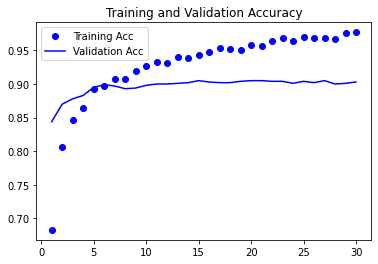

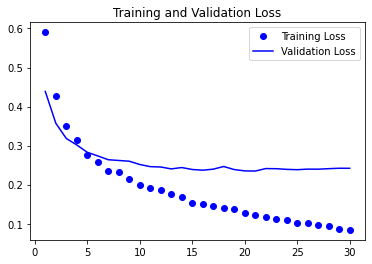

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Training Acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation Acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

약 90%의 검증 정확도에 도달했습니다. 하지만 이 모델은 드롭아웃을 사용했음에도 불구하고 훈련을 시작하면서 거의 바로 과대적합이 시작되었습니다. 작은 이미지 데이터셋에서는 과대적합을 막기위해 필수적으로 데이터 증식을 사용해야합니다.

#### 데이터 증식을 사용한 특성 추출

이제 특성 추출을 위해 두 번째로 언급한 방법을 살펴보겠습니다. 이 방법은 훨씬 느리고 비용이 많이 들지만 훈련하는 동안 데이터 증식 기법을 사용할 수 있습니다. **conv_base** 모델을 확장하고 입력 데이터를 사용하여 엔드-투-엔드로 실행합니다.

모델은 층과 동일하게 작동하므로 층을 추가하듯이 Sequential 모델에 다른 모델을 추가할 수 있습니다.

합성곱 기반 층 위에 완전 연결 분류기 추가하기

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


VGG16의 합성곱 기반 층은 1400만개의 매우 많은 파라미터를 가지고 있습니다. 합성곱 기반 층 위에 추가한 분류기는 200만개의 파라미터를 가집니다.

모델을 컴파일하고 훈련하기 전에 합성곱 기반 층을 **동결 (freeze)**하는 것이 매우 중요합니다. 하나 이상의 층을 **동결**한다는 것은 훈련하는 동안 가중치가 업데이트되지 않도록 막는다는 것입니다. 이렇게 하지 않으면 합성곱 기반 층에 의해 사전에 학습된 표현이 훈련하는 동안 수정될 것입니다.

##### 합성곱 기반 층 동결 시키기

In [10]:
conv_base.trainable = False

이렇게 하면 추가한 2개의 Dense 층의 가중치만 훈련될 것입니다. 층마다 2개씩 (가중치 행렬과 편향 벡터) 총 4개의 텐서가 훈련됩니다.

동결된 합성곱 기반 층과 함께 모델을 엔드-투-엔드로 훈련하기

In [11]:
import os, shutil

original_data_set_dir = './data/dogs_and_cats/train/'

base_dir = './data/dogs_and_cats_small/'

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

train_cats_dir = os.path.join(train_dir, "cats")
validation_cats_dir = os.path.join(validation_dir, "cats")
test_cats_dir = os.path.join(test_dir, "cats")

train_dogs_dir = os.path.join(train_dir, "dogs")
validation_dogs_dir = os.path.join(validation_dir, "dogs")
test_dogs_dir = os.path.join(test_dir, "dogs")   

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 20,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1,
                                   shear_range = 0.1,
                                   zoom_range = 0.1,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size = (150, 150),
                                                        batch_size = 20,
                                                        class_mode = 'binary')

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 2e-5),
              metrics = ['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch = 100,
                              epochs = 30,
                              validation_data = validation_generator,
                              validation_steps = 50,
                              verbose = 2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30


/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


100/100 - 9s - loss: 0.5515 - acc: 0.7365 - val_loss: 0.4117 - val_acc: 0.8420
Epoch 2/30
100/100 - 8s - loss: 0.4046 - acc: 0.8350 - val_loss: 0.3365 - val_acc: 0.8740
Epoch 3/30
100/100 - 8s - loss: 0.3519 - acc: 0.8565 - val_loss: 0.2988 - val_acc: 0.8870
Epoch 4/30
100/100 - 8s - loss: 0.3126 - acc: 0.8780 - val_loss: 0.2912 - val_acc: 0.8850
Epoch 5/30
100/100 - 8s - loss: 0.3035 - acc: 0.8735 - val_loss: 0.2685 - val_acc: 0.8920
Epoch 6/30
100/100 - 8s - loss: 0.2842 - acc: 0.8780 - val_loss: 0.2571 - val_acc: 0.8970
Epoch 7/30
100/100 - 8s - loss: 0.2737 - acc: 0.8910 - val_loss: 0.2518 - val_acc: 0.8980
Epoch 8/30
100/100 - 8s - loss: 0.2616 - acc: 0.9000 - val_loss: 0.2611 - val_acc: 0.8950
Epoch 9/30
100/100 - 8s - loss: 0.2545 - acc: 0.8980 - val_loss: 0.2513 - val_acc: 0.8930
Epoch 10/30
100/100 - 8s - loss: 0.2473 - acc: 0.8930 - val_loss: 0.2432 - val_acc: 0.9010
Epoch 11/30
100/100 - 8s - loss: 0.2416 - acc: 0.9000 - val_loss: 0.2453 - val_acc: 0.8950
Epoch 12/30
100/100

In [13]:
model.save('cats_and_dogs_small_3.h5')

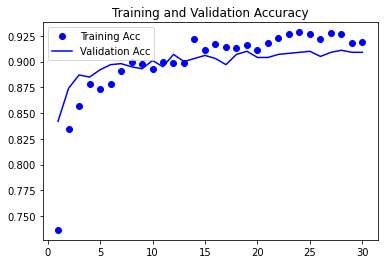

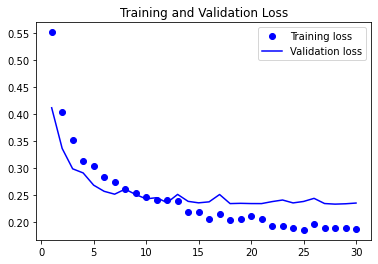

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, "bo", label = "Training Acc")
plt.plot(epochs, val_acc, "b", label = "Validation Acc")
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label = "Training loss")
plt.plot(epochs, val_loss, "b", label = "Validation loss")
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### 미세 조정 (Fine Tuning)

모델을 재사용하는데 널리 사용되는 또 하나의 길법은 특성 추출을 보완하는 **미세 조정 (fine-tuning)**입니다. 미세 조정은 특성 추출에 사용했던 동결 모델의 상위 층 몇개를 동결에서 해제하고 모델에 새로 추가한 층과 함께 훈련하는 것입니다. 주어진 문제에 조금 더 밀접하게 재사용 모델의 표현을 일부 조정하기 때문에 **미세 조정**이라고 부릅니다.

<br></br>
![](../images/5-3-Finetune.png)
<br></br>

앞서 랜덤하게 초기화된 상단 분류기를 훈련하기 위해 VGG16의 합성곱 기반 층을 동결하였습니다. 같은 이유로 맨 위에 있는 분류기가 훈련된 후 합성곱 기반의 상위 층을 미세 조정할 수 있습니다. 분류기가 미리 훈련되지 않으면 훈련되는 동안 너무 큰 오차 신호가 네트워크에 전파됩니다. 이는 메시 조정될 층들이 사전에 학습할 표현들을 망가뜨리게 됩니다. 네트워크를 미세 조정하는 단계는 다음과 같습니다.

1. 사전에 훈련된 기반 네트워크 위에 새로운 네트워크를 추가합니다
2. 기반 네트워크를 동결합니다
3. 새로 추가한 네트워크를 훈련합니다
4. 기반 네트워크에서 일부 층의 동결을 해제합니다
5. 동결을 해제한 층과 새로 추가한 층을 함께 훈련합니다

처음 3개의 단계는 특성 추출할때 이미 완료했습니다. 네번재 단계부터 진행하겠습니다. conv_base의 동결을 해제하고 개별 층을 동결하겠습니다.

In [15]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

마지막 3개의 합성곱 층을 미세 조정하겠습니다. 즉 `block4_pool`까지 모든 층은 동결되고 `block5_conv1`, `block5_conv2`, `block5_conv3`층은 학습 대상이 됩니다.

왜 더 많은 층을 미세 조정하지 않을까요?
* 합성곱 기반 층에 잇는 하위 층들은 좀 더 일반적이고 재사용 가능한 특성들을 인코딩합니다. 반면 상위층은 좀 더 특화된 특성을 인코딩합니다. 새로운 문제에 재활용하도록 수정이 필요한 것은 구체적인 특성이므로 이들을 미세 조정하는 것이 유리합니다
* 훈련해야 할 파라미터가 많을 수록 과대적합의 위험이 커집니다.

그러므로 이런 상황에서는 합성곱 기반 층에서 최상위 2~3개 층만 미세 조정하는 것이 좋습니다

##### 특정 층까지 모든 층 동결하기

In [16]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

##### 모델 미세 조정하기

In [17]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.RMSprop(lr = 1e-5),
              metrics = ['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch = 100,
                              epochs = 100,
                              validation_data = validation_generator,
                              validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 9s 85ms/step - loss: 0.2108 - acc: 0.9182 - val_loss: 0.2375 - val_acc: 0.8990
Epoch 2/100
100/100 [==============================] - 8s 84ms/step - loss: 0.1793 - acc: 0.9231 - val_loss: 0.2204 - val_acc: 0.9130
Epoch 3/100
100/100 [==============================] - 8s 84ms/step - loss: 0.1383 - acc: 0.9469 - val_loss: 0.2328 - val_acc: 0.9140
Epoch 4/100
100/100 [==============================] - 8s 84ms/step - loss: 0.1246 - acc: 0.9493 - val_loss: 0.2261 - val_acc: 0.9160
Epoch 5/100
100/100 [==============================] - 8s 84ms/step - loss: 0.0804 - acc: 0.9706 - val_loss: 0.2208 - val_acc: 0.9220
Epoch 6/100
100/100 [==============================] - 8s 84ms/step - loss: 0.0893 - acc: 0.9616 - val_loss: 0.2652 - val_acc: 0.9060
Epoch 7/100
100/100 [==============================] - 8s 84ms/step - loss: 0.0818 - acc: 0.9700 - val_loss: 0.2092 - val_acc: 0.9290
Epoch 8/100
100/100 [==============================] - 8s 83ms

Epoch 62/100
100/100 [==============================] - 9s 88ms/step - loss: 0.0040 - acc: 0.9980 - val_loss: 0.3143 - val_acc: 0.9290
Epoch 63/100
100/100 [==============================] - 9s 88ms/step - loss: 0.0036 - acc: 0.9995 - val_loss: 0.3258 - val_acc: 0.9260
Epoch 64/100
100/100 [==============================] - 9s 87ms/step - loss: 5.1716e-04 - acc: 1.0000 - val_loss: 0.3512 - val_acc: 0.9360
Epoch 65/100
100/100 [==============================] - 9s 88ms/step - loss: 0.0121 - acc: 0.9977 - val_loss: 0.3420 - val_acc: 0.9310
Epoch 66/100
100/100 [==============================] - 9s 87ms/step - loss: 0.0031 - acc: 0.9992 - val_loss: 0.3637 - val_acc: 0.9310
Epoch 67/100
100/100 [==============================] - 9s 87ms/step - loss: 0.0073 - acc: 0.9956 - val_loss: 0.3514 - val_acc: 0.9350
Epoch 68/100
100/100 [==============================] - 9s 88ms/step - loss: 0.0033 - acc: 0.9991 - val_loss: 0.4237 - val_acc: 0.9320
Epoch 69/100
100/100 [=============================

In [18]:
model.save('cats_and_dogs_small_4.h5')

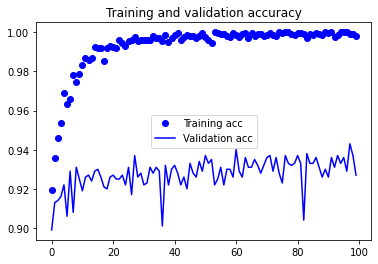

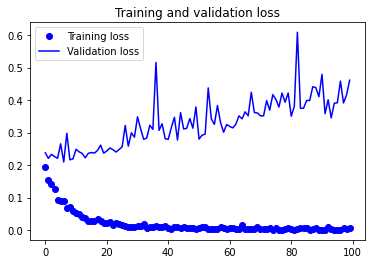

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

그래프가 불규칙하게 보입니다. 그래프를 보기 쉽게 하기위해 **지수 이동 평균 (exponential moving average)**로 정확도와 손실 값을 부드럽게 표현합니다.

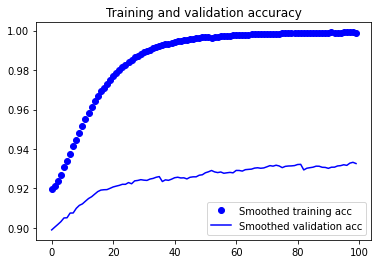

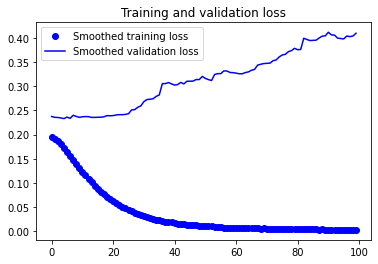

In [20]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
        
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

손실 곡선은 실제 어떤 향상을 얻지 못했습니다. 손실이 감소되지 않았는데 어떻게 정확도가 안정되거나 향상될 수 있을까요? 그래프는 개별적인 소실값의 평균을 그린 것입니다. 하지만 정확도에 영향을 미치는 것은 손실 값의 분포이지 평균이 아닙니다. 정확도는 모델이 예측한 클래스 확률이 어떤 임게 값을 넘었는지에 대한 결과이기 떄문입니다. 모델이 더 향상되더라도 평균 손실에 반영되지 않을 수 있습니다.

In [21]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps = 50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.


/home/jhhur/anaconda3/envs/TIL/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


test acc: 0.9300000071525574


약 93%의 정확도를 얻었습니다.